# Subsetting and retrieval of global sealevel/ssh observation data
If you prefer to interact with a Python script instead, you can convert this notebook to *.py with `jupyter nbconvert --to script subset_retrieve_sealevel_observations.ipynb`.


In [3]:
import os
import glob
import matplotlib.pyplot as plt
import xarray as xr
import dfm_tools as dfmt


To get an overview of the largest publicly available global sealevel observation datasets, we use `dfmt.ssh_catalog_subset()` with the `source` argument. For IOC and GESLA3 we also subset to highlight where they add significantly to the global spatial spatial coverage.

In [4]:
# ssc_catalog_gpd = dfmt.ssh_catalog_subset(source='ssc') # no data, only station locations
gesla_catalog_gpd = dfmt.ssh_catalog_subset(source='gesla3') # requires p-drive connection or download yourself
ioc_catalog_gpd = dfmt.ssh_catalog_subset(source='ioc')
cmems_list_gpd = dfmt.ssh_catalog_subset(source='cmems')
uhslc_json_rqds = dfmt.ssh_catalog_subset(source='uhslc-rqds')
uhslc_json_fast = dfmt.ssh_catalog_subset(source='uhslc-fast')
psmsl_gnssir_gpd = dfmt.ssh_catalog_subset(source='psmsl-gnssir')
rwsddl_gpd = dfmt.ssh_catalog_subset(source='rwsddl')
gtsm_era5_gpd = dfmt.ssh_catalog_subset(source='gtsm-era5-cds')

# subsetting gesla
bool_ndays = gesla_catalog_gpd["time_ndays"] > 365
bool_country = gesla_catalog_gpd['country'].isin(['CAN','GRL'])
bool_contrib = gesla_catalog_gpd['contributor_abbreviated'].isin(['MEDS',"GLOSS"])
gesla_catalog_gpd_sel = gesla_catalog_gpd.loc[bool_country & bool_contrib & bool_ndays]

# subsetting ioc
bool_ndays = ioc_catalog_gpd["time_ndays"] > 365
bool_country = ioc_catalog_gpd['country'].isin(['RUS','IND']) #,'TUR','ISR','CYP','KRS','HRV','HEL'])
ioc_catalog_gpd_sel = ioc_catalog_gpd.loc[bool_ndays & bool_country]

# subsetting gtsm-era5 - exclude grid points in the open water 
gtsm_era5_gpd_sel = gtsm_era5_gpd.loc[~gtsm_era5_gpd['station_name_unique'].str.contains(r'grid', na=False)]


INFO - 2025-03-05T16:31:43Z - Checking if credentials are valid.
INFO - 2025-03-05T16:31:43Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:31:44Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:31:44Z - Selected dataset part: "history"
INFO - 2025-03-05T16:31:44Z - Listing files on remote server...
1it [00:00,  5.36it/s]


>> reading coastlines: 1.99 sec
>> reading country borders: 0.02 sec


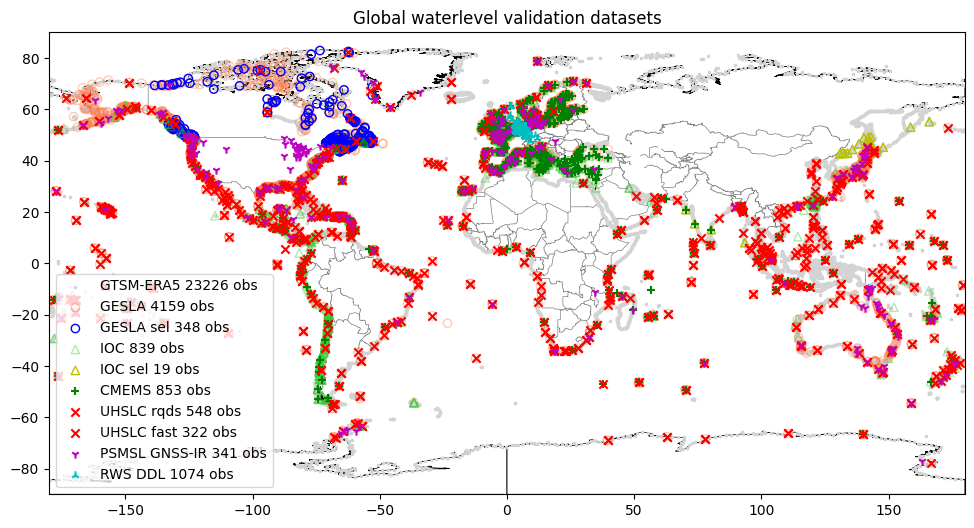

In [5]:
# plot stations
fig,ax = plt.subplots(figsize=(14,6))
gtsm_era5_gpd_sel.geometry.plot(ax=ax,marker="x", color="lightgray", markersize=3, label=f'GTSM-ERA5 {len(gtsm_era5_gpd_sel)} obs')
gesla_catalog_gpd.geometry.plot(ax=ax, marker="o", color="coral", facecolor="none", label=f"GESLA {len(gesla_catalog_gpd)} obs", alpha=0.4)
gesla_catalog_gpd_sel.geometry.plot(ax=ax, marker="o", color="b", facecolor="none", label=f"GESLA sel {len(gesla_catalog_gpd_sel)} obs")
ioc_catalog_gpd.geometry.plot(ax=ax, marker="^", color="limegreen", facecolor="none", label=f"IOC {len(ioc_catalog_gpd)} obs", alpha=0.4)
ioc_catalog_gpd_sel.geometry.plot(ax=ax, marker="^", color="y", facecolor="none", label=f"IOC sel {len(ioc_catalog_gpd_sel)} obs")
cmems_list_gpd.geometry.plot(ax=ax, marker="+", color="g", label=f"CMEMS {len(cmems_list_gpd)} obs")
uhslc_json_rqds.geometry.plot(ax=ax, marker="x", color="r", label=f"UHSLC rqds {len(uhslc_json_rqds)} obs")
uhslc_json_fast.geometry.plot(ax=ax, marker="x", color="r", label=f"UHSLC fast {len(uhslc_json_fast)} obs")
psmsl_gnssir_gpd.geometry.plot(ax=ax, marker="1", color="m", label=f"PSMSL GNSS-IR {len(psmsl_gnssir_gpd)} obs")
rwsddl_gpd.geometry.plot(ax=ax, marker="2", color="c", label=f"RWS DDL {len(rwsddl_gpd)} obs")

ax.set_xlim(-181,181)
ax.set_ylim(-90,90)
ax.legend(loc=3)
ax.set_title("Global waterlevel validation datasets")
ax.set_xlim(-180,180)
dfmt.plot_coastlines(ax=ax, min_area=1000, linewidth=0.5, zorder=0)
dfmt.plot_borders(ax=ax, zorder=0)


Next, we will subset all sources in time and space by providing more arguments to `dfmt.ssh_catalog_subset`. The stations with data in this period and area are plotted. 

INFO - 2025-03-05T16:37:09Z - Checking if credentials are valid.
INFO - 2025-03-05T16:37:09Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:37:10Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:37:10Z - Selected dataset part: "history"
INFO - 2025-03-05T16:37:10Z - Listing files on remote server...
1it [00:00,  5.05it/s]


retrieving psmsl-gnssir time extents for 12 stations: 1 2 3 4 5 6 7 8 9 10 11 12 
>> reading coastlines: 1.15 sec
>> reading country borders: 0.03 sec


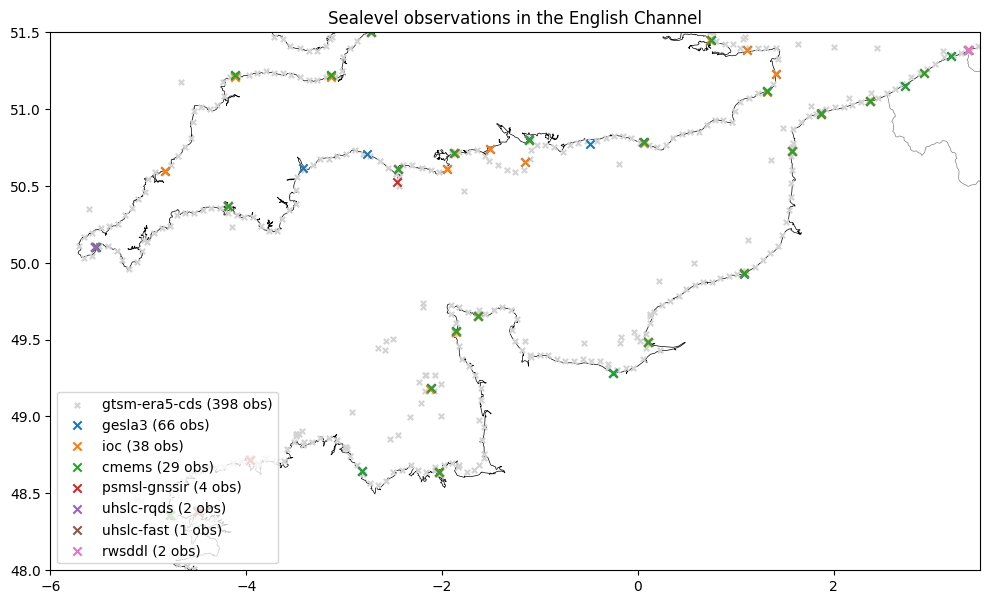

In [11]:
dir_output = "./sealevel_data_subset"
os.makedirs(dir_output, exist_ok=True)

lon_min, lon_max, lat_min, lat_max = -6, 3.5, 48, 51.5 # france
# lon_min, lon_max, lat_min, lat_max = 123, 148, 23, 47 # japan
# lon_min, lon_max, lat_min, lat_max = -20, 40, 25, 72 # europe
time_min, time_max = '2016-01-01','2016-02-01'

subset_kwargs = dict(lon_min=lon_min, lon_max=lon_max, lat_min=lat_min, lat_max=lat_max, 
                     time_min=time_min, time_max=time_max)
gesla_catalog_gpd_sel = dfmt.ssh_catalog_subset(source='gesla3', **subset_kwargs)
ioc_catalog_gpd_sel = dfmt.ssh_catalog_subset(source='ioc', **subset_kwargs)
cmems_list_gpd_sel = dfmt.ssh_catalog_subset(source='cmems', **subset_kwargs)
uhslc_json_rqds_sel = dfmt.ssh_catalog_subset(source='uhslc-rqds', **subset_kwargs)
uhslc_json_fast_sel = dfmt.ssh_catalog_subset(source='uhslc-fast', **subset_kwargs)
psmsl_gnssir_gpd_sel = dfmt.ssh_catalog_subset(source='psmsl-gnssir', **subset_kwargs)

# TODO: no time subsetting supported for rwsddl and gtsm-era5-cds
for key in ["time_min", "time_max"]:
    subset_kwargs.pop(key)
rwsddl_gpd_sel = dfmt.ssh_catalog_subset(source='rwsddl', **subset_kwargs)
gtsm_era5_gpd_sel = dfmt.ssh_catalog_subset(source='gtsm-era5-cds', **subset_kwargs)
gtsm_era5_gpd_sel = gtsm_era5_gpd_sel.loc[~gtsm_era5_gpd_sel['station_name_unique'].str.contains(r'grid')] # exclude gridded points in open water
subset_gpd_list = [gtsm_era5_gpd_sel, gesla_catalog_gpd_sel,
                  ioc_catalog_gpd_sel, cmems_list_gpd_sel,
                  psmsl_gnssir_gpd_sel, uhslc_json_rqds_sel,
                  uhslc_json_fast_sel, rwsddl_gpd_sel]

# plot stations
fig,ax = plt.subplots(figsize=(12,7))
for subset_gpd in subset_gpd_list:
    if subset_gpd.empty:
        continue
    source = subset_gpd.iloc[0]["source"]
    nstations = len(subset_gpd)
    if source == 'gtsm-era5-cds':
        subset_gpd.geometry.plot(ax=ax, marker="x", color="lightgray", markersize=15, label=f"{source} ({nstations} obs)")
    else:
        subset_gpd.geometry.plot(ax=ax, marker="x", label=f"{source} ({nstations} obs)")
ax.legend(loc=3)
ax.set_title("Sealevel observations in the English Channel")
ax.set_xlim(lon_min, lon_max)
ax.set_ylim(lat_min, lat_max)
dfmt.plot_coastlines(ax=ax, min_area=1000, linewidth=0.5, zorder=0)
dfmt.plot_borders(ax=ax, zorder=0)

This data is retrieved with `dfmt.ssh_retrieve_data`. Since GESLA and IOC do not provide additional spatial coverage here, these datasets are skipped.

In [12]:
# retrieve data (for all except gesla and ioc)
subset_gpd_list_retrieve = [cmems_list_gpd_sel, psmsl_gnssir_gpd_sel,
                            uhslc_json_rqds_sel, uhslc_json_fast_sel,
                            rwsddl_gpd_sel, gtsm_era5_gpd_sel]

for subset_gpd in subset_gpd_list_retrieve:
    dfmt.ssh_retrieve_data(subset_gpd, dir_output,
                           time_min=time_min, time_max=time_max)


INFO - 2025-03-05T16:37:28Z - Checking if credentials are valid.


retrieving data for 29 cmems stations: 1 

INFO - 2025-03-05T16:37:29Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:37:29Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:37:29Z - Selected dataset part: "history"
INFO - 2025-03-05T16:37:30Z - Listing files on remote server...
INFO - 2025-03-05T16:37:31Z - Checking if credentials are valid.


2 

INFO - 2025-03-05T16:37:32Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:37:32Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:37:32Z - Selected dataset part: "history"
INFO - 2025-03-05T16:37:33Z - Listing files on remote server...
INFO - 2025-03-05T16:37:35Z - Checking if credentials are valid.


3 

INFO - 2025-03-05T16:37:35Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:37:36Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:37:36Z - Selected dataset part: "history"
INFO - 2025-03-05T16:37:37Z - Listing files on remote server...
INFO - 2025-03-05T16:37:38Z - Checking if credentials are valid.


4 

INFO - 2025-03-05T16:37:39Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:37:40Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:37:40Z - Selected dataset part: "history"
INFO - 2025-03-05T16:37:40Z - Listing files on remote server...
INFO - 2025-03-05T16:37:42Z - Checking if credentials are valid.


5 

INFO - 2025-03-05T16:37:42Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:37:43Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:37:43Z - Selected dataset part: "history"
INFO - 2025-03-05T16:37:46Z - Listing files on remote server...
INFO - 2025-03-05T16:37:50Z - Checking if credentials are valid.


6 

INFO - 2025-03-05T16:37:50Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:37:51Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:37:51Z - Selected dataset part: "history"
INFO - 2025-03-05T16:37:52Z - Listing files on remote server...
INFO - 2025-03-05T16:37:55Z - Checking if credentials are valid.


7 

INFO - 2025-03-05T16:37:55Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:37:56Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:37:56Z - Selected dataset part: "history"
INFO - 2025-03-05T16:37:58Z - Listing files on remote server...
INFO - 2025-03-05T16:38:00Z - Checking if credentials are valid.


8 

INFO - 2025-03-05T16:38:00Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:38:01Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:38:01Z - Selected dataset part: "history"
INFO - 2025-03-05T16:38:01Z - Listing files on remote server...
INFO - 2025-03-05T16:38:03Z - Checking if credentials are valid.


9 

INFO - 2025-03-05T16:38:04Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:38:05Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:38:05Z - Selected dataset part: "history"
INFO - 2025-03-05T16:38:05Z - Listing files on remote server...
INFO - 2025-03-05T16:38:07Z - Checking if credentials are valid.


10 

INFO - 2025-03-05T16:38:07Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:38:08Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:38:08Z - Selected dataset part: "history"
INFO - 2025-03-05T16:38:08Z - Listing files on remote server...
INFO - 2025-03-05T16:38:11Z - Checking if credentials are valid.


[NODATA] [NODATA] 11 

INFO - 2025-03-05T16:38:11Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:38:12Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:38:12Z - Selected dataset part: "history"
INFO - 2025-03-05T16:38:12Z - Listing files on remote server...
INFO - 2025-03-05T16:38:14Z - Checking if credentials are valid.


12 

INFO - 2025-03-05T16:38:14Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:38:15Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:38:15Z - Selected dataset part: "history"
INFO - 2025-03-05T16:38:16Z - Listing files on remote server...
INFO - 2025-03-05T16:38:17Z - Checking if credentials are valid.


13 

INFO - 2025-03-05T16:38:18Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:38:18Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:38:18Z - Selected dataset part: "history"
INFO - 2025-03-05T16:38:19Z - Listing files on remote server...
INFO - 2025-03-05T16:38:20Z - Checking if credentials are valid.


[NODATA] [NODATA] 14 

INFO - 2025-03-05T16:38:21Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:38:22Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:38:22Z - Selected dataset part: "history"
INFO - 2025-03-05T16:38:22Z - Listing files on remote server...
INFO - 2025-03-05T16:38:23Z - Checking if credentials are valid.


15 

INFO - 2025-03-05T16:38:24Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:38:25Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:38:25Z - Selected dataset part: "history"
INFO - 2025-03-05T16:38:25Z - Listing files on remote server...
INFO - 2025-03-05T16:38:27Z - Checking if credentials are valid.


16 

INFO - 2025-03-05T16:38:28Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:38:29Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:38:29Z - Selected dataset part: "history"
INFO - 2025-03-05T16:38:29Z - Listing files on remote server...
INFO - 2025-03-05T16:38:31Z - Checking if credentials are valid.


17 

INFO - 2025-03-05T16:38:31Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:38:33Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:38:33Z - Selected dataset part: "history"
INFO - 2025-03-05T16:38:33Z - Listing files on remote server...
INFO - 2025-03-05T16:38:35Z - Checking if credentials are valid.


18 

INFO - 2025-03-05T16:38:35Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:38:36Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:38:36Z - Selected dataset part: "history"
INFO - 2025-03-05T16:38:37Z - Listing files on remote server...
INFO - 2025-03-05T16:38:38Z - Checking if credentials are valid.


19 

INFO - 2025-03-05T16:38:38Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:38:39Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:38:39Z - Selected dataset part: "history"
INFO - 2025-03-05T16:38:40Z - Listing files on remote server...
INFO - 2025-03-05T16:38:41Z - Checking if credentials are valid.


20 

INFO - 2025-03-05T16:38:42Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:38:42Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:38:42Z - Selected dataset part: "history"
INFO - 2025-03-05T16:38:43Z - Listing files on remote server...
INFO - 2025-03-05T16:38:44Z - Checking if credentials are valid.


21 

INFO - 2025-03-05T16:38:45Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:38:45Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:38:45Z - Selected dataset part: "history"
INFO - 2025-03-05T16:38:47Z - Listing files on remote server...
INFO - 2025-03-05T16:38:48Z - Checking if credentials are valid.


[NODATA] [NODATA] 22 

INFO - 2025-03-05T16:38:48Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:38:49Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:38:49Z - Selected dataset part: "history"
INFO - 2025-03-05T16:38:49Z - Listing files on remote server...
INFO - 2025-03-05T16:38:51Z - Checking if credentials are valid.


23 

INFO - 2025-03-05T16:38:51Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:38:52Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:38:52Z - Selected dataset part: "history"
INFO - 2025-03-05T16:38:53Z - Listing files on remote server...
INFO - 2025-03-05T16:38:55Z - Checking if credentials are valid.


24 

INFO - 2025-03-05T16:38:55Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:38:56Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:38:56Z - Selected dataset part: "history"
INFO - 2025-03-05T16:38:56Z - Listing files on remote server...
INFO - 2025-03-05T16:38:58Z - Checking if credentials are valid.


25 

INFO - 2025-03-05T16:38:58Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:38:59Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:38:59Z - Selected dataset part: "history"
INFO - 2025-03-05T16:38:59Z - Listing files on remote server...
INFO - 2025-03-05T16:39:00Z - Checking if credentials are valid.


26 

INFO - 2025-03-05T16:39:01Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:39:02Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:39:02Z - Selected dataset part: "history"
INFO - 2025-03-05T16:39:02Z - Listing files on remote server...
INFO - 2025-03-05T16:39:04Z - Checking if credentials are valid.


27 

INFO - 2025-03-05T16:39:04Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:39:05Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:39:05Z - Selected dataset part: "history"
INFO - 2025-03-05T16:39:06Z - Listing files on remote server...
INFO - 2025-03-05T16:39:07Z - Checking if credentials are valid.


28 

INFO - 2025-03-05T16:39:07Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:39:08Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:39:08Z - Selected dataset part: "history"
INFO - 2025-03-05T16:39:09Z - Listing files on remote server...
INFO - 2025-03-05T16:39:10Z - Checking if credentials are valid.


29 

INFO - 2025-03-05T16:39:10Z - Valid credentials from configuration file.
INFO - 2025-03-05T16:39:11Z - Selected dataset version: "202411"
INFO - 2025-03-05T16:39:11Z - Selected dataset part: "history"
INFO - 2025-03-05T16:39:12Z - Listing files on remote server...



retrieving data for 4 psmsl-gnssir stations: 1 2 3 4 
retrieving data for 2 uhslc-rqds stations: 1 2 
retrieving data for 1 uhslc-fast stations: 1 
retrieving data for 2 rwsddl stations: 1 

100%|██████████| 1/1 [00:01<00:00,  1.56s/it]


2 

100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


[NODATA] 
retrieving data for 398 gtsm-era5-cds stations: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 26

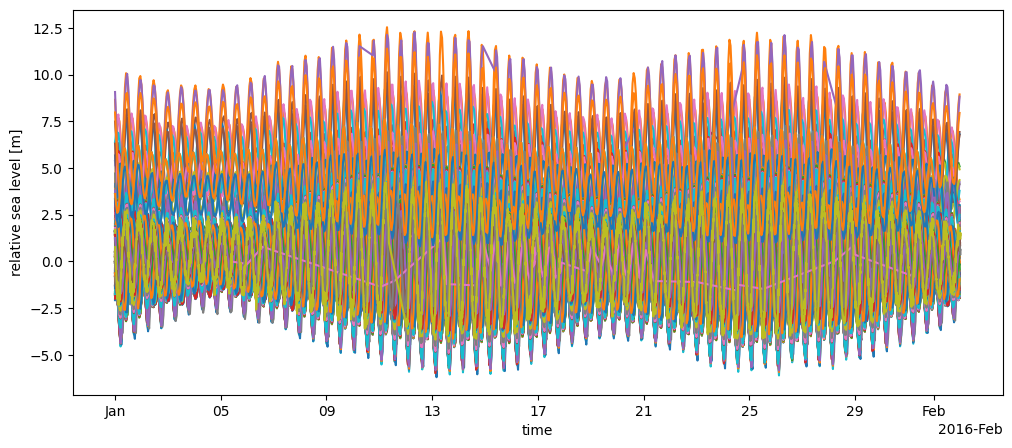

In [15]:
# plot the retrieved datasets
fig,ax = plt.subplots(figsize=(12,5))
file_list = glob.glob(os.path.join(dir_output, "*.nc"))
file_list.sort()
for file_nc in file_list:
    ds = xr.open_dataset(file_nc)
    station_name = os.path.basename(file_nc).strip(".nc")
    ds.waterlevel.plot(ax=ax, label=station_name)
    del ds
# ax.legend(loc=1, fontsize=8)


creating overview for 432 files: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269

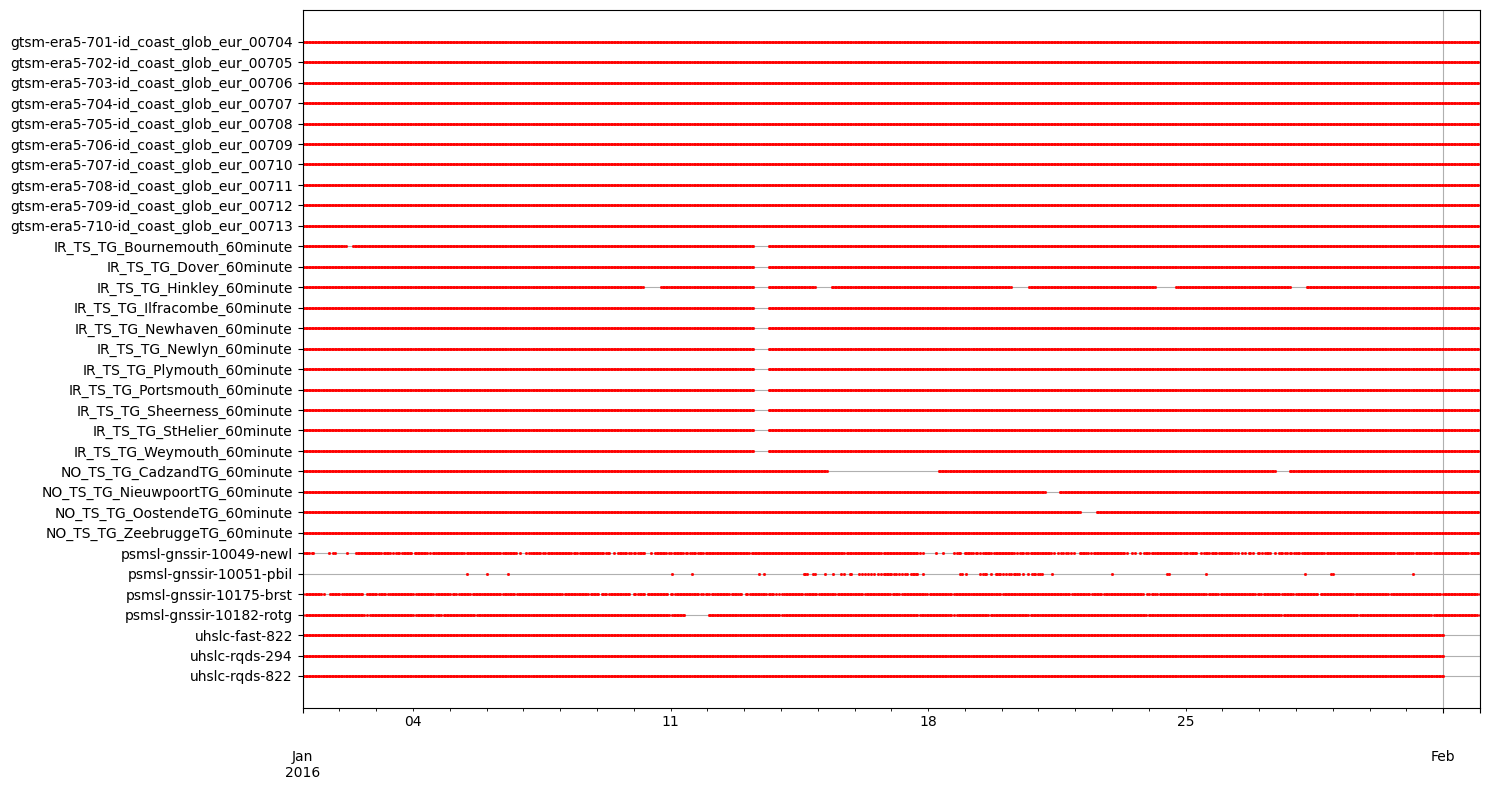

In [14]:
# create overview plot and statistics csv
dfmt.ssh_netcdf_overview(dir_output, perplot=40)
